In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [3]:
pip install cv2

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [2]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf

import importlib
from tensorflow import keras

from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

ModuleNotFoundError: No module named 'cv2'

In [118]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = r"/content/drive/MyDrive/few-shot-learning/val/whale"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    print("error1 in path")
    image = cv2.imread(path)
    print(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print("error3")
    image=cv2.resize(image,(128,128))
    return image

In [119]:
# Zileanous testing ground
import os
import glob

def read_image(index):
    folder, _ = index
    path = os.path.join(ROOT, folder)

    # Get a list of all image files in the folder
    image_files = glob.glob(os.path.join(path, '*'))

    # If there are no image files, return None
    if not image_files:
        print(f"No image files in folder: {path}")
        return None

    # Sort the image files and select the first one
    image_file = sorted(image_files)[0]

    # Read and convert the image
    try:
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(128,128))
    except Exception as e:
        print(f"Error reading file {image_file}: {e}")
        return None

    return img



In [120]:
import tensorflow as tf
batch_size = 128
def split_dataset(directory):
    folders = os.listdir(directory)
    num_test = int(len(folders))

    random.shuffle(folders)

    test_list= {}



    # Creating Test-list
    for folder in folders[:num_test]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files

    return test_list

test_list  = split_dataset(ROOT)

print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)





Length of testing list : 17

Test List: {'61': 8, '53': 9, '52': 8, '51': 12, '59': 8, '55': 8, '56': 9, '57': 9, '58': 9, '60': 11, '64': 11, '65': 8, '62': 8, '66': 9, '67': 9, '63': 9, '54': 12}


In [121]:
# # Assuming anchor, positive, negative are your input tensors
# anchor = tf.random.normal([batch_size, 128, 128, 3])
# positive = tf.random.normal([batch_size, 128, 128, 3])
# negative = tf.random.normal([batch_size, 128, 128, 3])

# # Reshape the data
# anchor = tf.reshape(anchor, (batch_size, 128, 128, 3))
# positive = tf.reshape(positive, (batch_size, 128, 128, 3))
# negative = tf.reshape(negative, (batch_size, 128, 128, 3))

In [122]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))

    random.shuffle(triplets)
    return triplets

In [123]:

test_triplet  = create_triplets(ROOT, test_list)


print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(test_triplet[i])

Number of testing triplets : 600

Examples of triplets:
(('59', '0.jpg'), ('59', '5.jpg'), ('63', '0.jpg'))
(('57', '3.jpg'), ('57', '6.jpg'), ('55', '7.jpg'))
(('64', '0.jpg'), ('64', '1.jpg'), ('65', '3.jpg'))
(('55', '0.jpg'), ('55', '1.jpg'), ('59', '2.jpg'))
(('54', '0.jpg'), ('54', '7.jpg'), ('67', '5.jpg'))


In [124]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size

    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

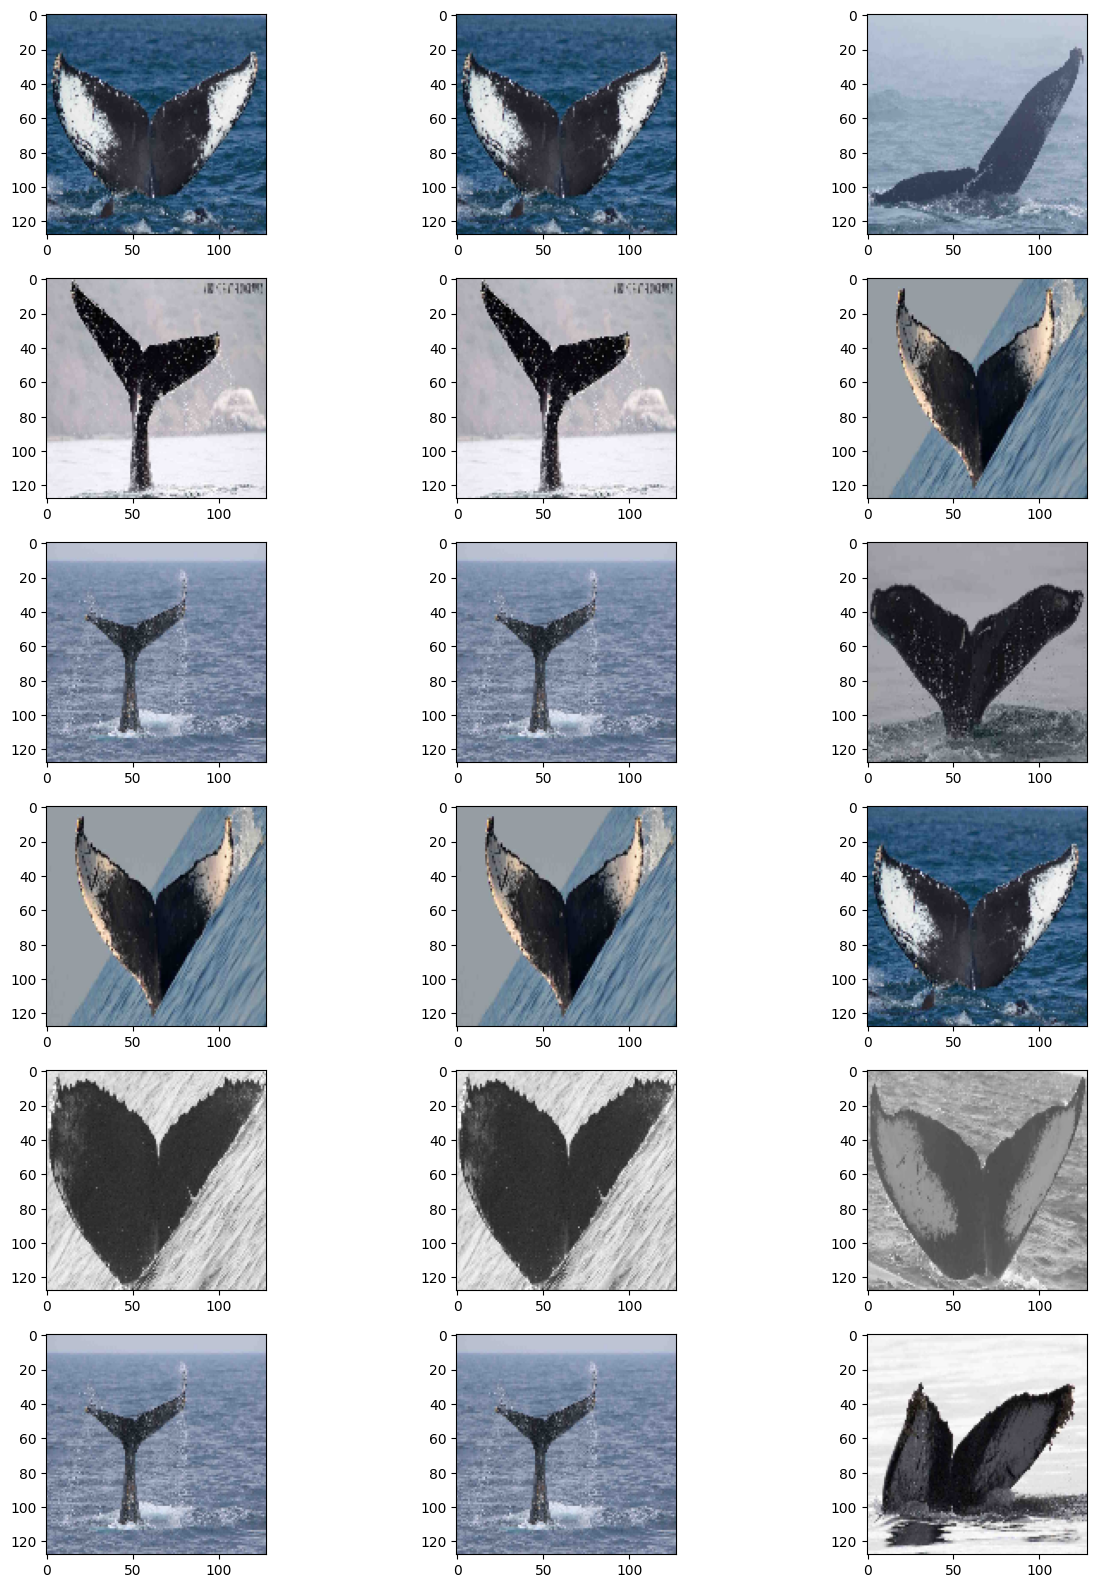

In [125]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(test_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [126]:
!pip install tensorflow
!pip install keras-applications
!pip install keras-preprocessing
import tensorflow
from tensorflow.keras import backend, layers, metrics
from keras.preprocessing import image as imagenet_utils
# from keras.preprocessing.image import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



In [127]:
# def get_encoder(input_shape):
#     """ Returns the image encoding model """

#     pretrained_model = Xception(
#         input_shape=input_shape,
#         weights='imagenet',
#         include_top=False,
#         pooling='avg',
#     )

#     for i in range(len(pretrained_model.layers)-27):
#         pretrained_model.layers[i].trainable = False

#     encode_model = Sequential([
#         pretrained_model,
#         layers.Flatten(),
#         layers.Dense(512, activation='relu'),
#         layers.BatchNormalization(),
#         layers.Dense(256, activation="relu"),
#         layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
#     ], name="Encode_Model")
#     return encode_model

In [128]:
import pickle

# # Specify the full path to the file
# file_path = '/content/drive/MyDrive/few-shot-learning/encoder.pkl'


# # Load the model
# with open(file_path, 'rb') as f:
#     encoder_loaded_model = pickle.load(f)
from tensorflow.keras.models import load_model
# #encoder = encoder_loaded_model
# encoder =encoder_loaded_model
encoder_loaded_model=load_model('/content/drive/MyDrive/few-shot-learning/model.h5')

In [129]:
import io
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


def get_siamese_network(input_shape = (128, 128, 3)):
    # encoder = load_model('/content/encoder.indexr')
    from pathlib import Path
    encoder = encoder_loaded_model

    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Anchor_Input (InputLayer)   [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Positive_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 Negative_Input (InputLayer  [(None, 128, 128, 3)]        0         []                            
 )                                                                                                
                                                                                    

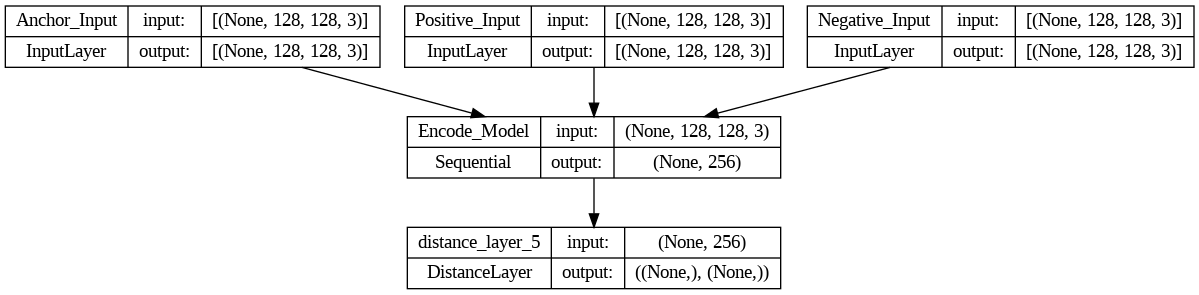

In [130]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [131]:
# @keras.saving.register_keras_serializable()
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [132]:
# print(anchor.shape)
# print(positive.shape)
# print(negative.shape)


In [133]:
# from tensorflow import keras


# file_path='/content/drive/MyDrive/few-shot-learning/siamese_model.pkl'

# # Now you can load your model
# with open(file_path, 'rb') as f:
#     loaded_model = pickle.load(f)


In [134]:
# model_save_path = '/content/drive/MyDrive/few-shot-learning/siamese'
# loaded_model = tf.keras.models.load_model(model_save_path, custom_objects={'SiameseModel': SiameseModel})


In [135]:
# siamese_model = loaded_model
# optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
# siamese_model.compile(optimizer=optimizer)


In [136]:
import numpy as np

def test_on_triplets(batch_size=256):
    pos_scores, neg_scores = [], []

    for batch in get_batch(test_triplet, batch_size=batch_size):
        # Unpack the data into anchor, positive, and negative
        anchor, positive, negative = batch

        # Convert lists to NumPy arrays
        anchor_np = np.array(anchor)
        positive_np = np.array(positive)
        negative_np = np.array(negative)

        # Pass the inputs to the model as separate arguments
        predictions = siamese_model.predict([anchor_np, positive_np, negative_np])

        pos_scores.extend(predictions[0].tolist())
        neg_scores.extend(predictions[1].tolist())

    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)




In [137]:
from tensorflow.keras.models import load_model
# #encoder = encoder_loaded_model
# encoder =encoder_loaded_model
encoder=load_model('/content/drive/MyDrive/few-shot-learning/model.h5')

In [138]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Convert the input lists to numpy arrays if they aren't already
    print("error")
    # face_list1 = np.array(face_list1)
    # face_list2 = np.array(face_list2)
    print("error2")
    # Ensure the input arrays have the correct number of dimensions
    # if len(face_list1.shape) == 1:
    #     face_list1 = np.expand_dims(face_list1, axis=0)
    # if len(face_list2.shape) == 1:
    #     face_list2 = np.expand_dims(face_list2, axis=0)
    # print("error3")
    # Getting the encodings for the passed faces
    print(np.shape(face_list1))
    print(np.shape(face_list2))
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)

    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


(256, 128, 128, 3)
(256, 128, 128, 3)
(256, 128, 128, 3)
error
error2
(256, 128, 128, 3)
(256, 128, 128, 3)
8/8 [==============================] - 18s 2s/step
error
error2
(256, 128, 128, 3)
(256, 128, 128, 3)
8/8 [==============================] - 18s 2s/step

Accuracy of model: 0.85546875



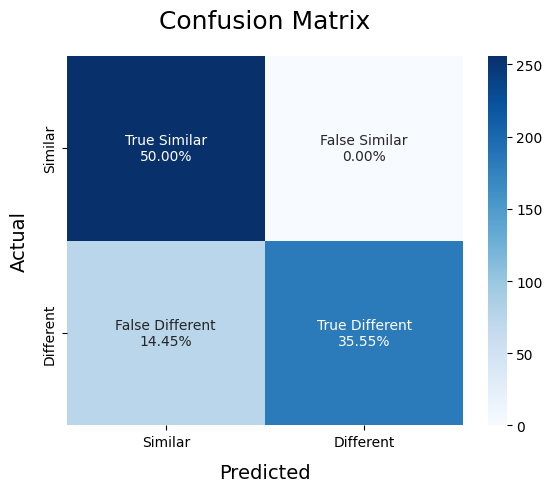

In [139]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)

    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    print(np.shape(a))
    print(np.shape(p))
    print(np.shape(n))

    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)